In [ ]:
## visualisation of the cocept space for the final print

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.vq import whiten
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_distances
import seaborn as sns
sns.set(style="white")
import cmcrameri.cm as cmc
import pacmap
#import trimap
#import umap
import random

h:\z\.conda\envs\data\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
h:\z\.conda\envs\data\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
h:\z\.conda\envs\data\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
v = 4.02
save_path = r"O:/projekter/PY000017_D/analysis/plots/%s/" %v
def rgb(hex):
    hex = hex[1:]
    rgb = []
    for i in (0, 2, 4):
        decimal = int(hex[i:i+2], 16)
        rgb.append(decimal/256)
    rgb.append(1)
    return tuple(rgb)

def plot_region(r):
    plt.hlines(y = r[0][0], xmin=r[1][0], xmax=r[1][1], linewidth=1.5, linestyle="dotted", color="black")
    plt.hlines(y = r[0][1], xmin=r[1][0], xmax=r[1][1], linewidth=1.5, linestyle="dotted", color="black")
    plt.vlines(x = r[1][0], ymin=r[0][0], ymax=r[0][1], linewidth=1.5, linestyle="dotted", color="black")
    plt.vlines(x = r[1][1], ymin=r[0][0], ymax=r[0][1], linewidth=1.5, linestyle="dotted", color="black")
    
def plot_square(s, width):
    sx = s[0]
    sy = s[1]
    plt.hlines(y = sy, xmin=sx, xmax=sx+width, linewidth=2, linestyle="dotted", color="black")
    
    plt.hlines(y = sy - width, xmin=sx, xmax=sx + width, linewidth=2, linestyle="dotted", color="black")
    plt.vlines(x = sx, ymin=sy-width, ymax=sy, linewidth=2, linestyle="dotted", color="black")
    plt.vlines(x = sx + width, ymin=sy-width, ymax=sy, linewidth=2, linestyle="dotted", color="black")

In [5]:
on_linux = False
if on_linux:
    vocab_path = r"/home/x90/kdrev/22SSI/Germans/processed/vocab/global_set/result.tsv"
    data_path = r"/home/x90/odrev/projekter/PY000017_D/logs/v15/pre_training/version_1.33/00029/token_embeddings/tensors.tsv"
else:
    vocab_path = r"K:\22SSI\Germans\processed\vocab\global_set\result.tsv"
    data_path = r"O:\projekter\PY000017_D\logs\v15\pre_training\version_1.33\00029\token_embeddings\tensors.tsv"
vocab = pd.read_csv(vocab_path, sep="\t").set_index("ID")
data = pd.read_csv(data_path, sep="\t", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
1,0.167417,0.099188,-0.058108,0.040996,0.063955,-0.106299,-0.046358,0.025037,0.027549,0.008847,...,0.080290,0.069454,-0.000393,-0.019714,0.090622,0.072291,-0.097848,0.029501,0.154484,-0.155077
2,-0.077346,-0.408066,-0.097774,0.134385,-0.239635,-0.006696,0.062762,0.081888,0.029233,-0.112830,...,-0.068163,-0.014016,0.087610,-0.004448,0.059474,-0.000954,-0.064938,0.026010,0.018132,0.181873
3,0.023972,0.063024,-0.049528,-0.054631,-0.105139,-0.068660,-0.014551,0.140277,-0.040421,-0.025114,...,0.374228,-0.075184,0.014032,-0.000618,0.105663,-0.059096,0.015161,-0.084069,-0.002832,0.148310
4,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000


In [6]:
le = LabelEncoder()
labels = le.fit_transform(vocab["CATEGORY"])
#print(le.classes_)
#for i, c in enumerate(le.classes_):
#    print(i,c)

In [7]:
c = []
cmap = cmc.batlowS
for l in labels:
    if l in [2, 3,4]: # C_ADIAG, C_INDM, C_PATTYPE
        c.append("#009E73") #sky blue
    elif l == 11:     # SALARY
        c.append(cmap(0))
    elif l==7:        # MUNICIPALITY
        c.append("#cc79a7") # reddish purple
    elif l in [6, 15]: # MONTH, YEAR
        c.append("#0072b2") #blue
    elif l in [1, 8, 9]: #BACKGROUND, SOC
        c.append("#e69f00") #orange
    elif l == 12: #WORK_INDUSTRY
        c.append("#999999") #vermilion
    elif l==13: #WORK_POSITION
        c.append("#d55e00") #vermilion
    else:
        c.append("#000000") #black
        
        
type_dict =  {0: "ATP Code (Tax)",
              1: "Diagnosis",
              2: "Urgency Status",
              3: "Diagnosis",
              4: "Patient Type",
              5: "General (Special) Tokens",
              6: "Months",
              7: "Municipality of Residence",
              8: "Labor-Force Modifier",
              9: "Labor-Force Status",
              10: "Labor-Force Interval",
              11: "Income Quantile",
              12: "Work Industry",
              13: "Professional Occupation",
              14: "Work Sector",
              15: "Year"}

In [8]:
x = data.values
x_ = np.delete(x, [0,4,5,6,7,8])
x -= x_.mean(0)
xh = whiten(x)

In [7]:
projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, random_state=0, MN_ratio=1, FP_ratio=10, distance="angular", lr=0.5)
xp = projector.fit_transform(xh)

h:\z\.conda\envs\data\lib\site-packages\pacmap\pacmap.py:774: UserWarning: Warning: random state is set to 0
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [8]:
x.shape

(2043, 280)

In [8]:
save_data = pd.DataFrame({"x_coord": xp[:,0],
                          "y_coord": xp[:,1],
                          "type": [type_dict[l] for l in labels],
                          "token": vocab["TOKEN"].values})
save_data.to_csv(save_path + "concept_embedding_projection.csv")

In [14]:
def insert_subplot(ax, region, box, s=70, linewidths=0.5, alpha=0.7, offset=0.1):
    # Create inset axes for region A.
    ax_inset = ax.inset_axes(box)  # These are figure coordinates.
    ax_inset.scatter(x_coords, y_coords, c=c,  s=s, edgecolors="white", linewidths=linewidths, alpha=alpha)
    ax_inset.set_xlim(region[0], region[1])
    ax_inset.set_ylim(region[2], region[3])
    # Connector Settings
    ax.indicate_inset_zoom(ax_inset,
                       edgecolor="black",
                       linestyle= (0,(0,0,1,1)),  
                       linewidth=2.5,   
                       )
    # Labels and Axis
    for spine in ax_inset.spines.values():
        spine.set_linestyle((0,(0,0,2,2.5))) 
        spine.set_visible(True)
    ax_inset.set_xticklabels([])
    ax_inset.set_yticklabels([])
    ax_inset.tick_params(axis='both', which='both', length=0)
    
    # Annotations    
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        if (region[0]+ offset) <= x<= (region[1] - offset) and (region[2] + offset) <= y <= (region[3] - offset):
            label = v[i]  # This is your annotation text, replace it with your desired text
            ax_inset.annotate(process_text(label),  # This is the text to use for the annotation
                    (x, y),  # This sets the location of the point to annotate
                    textcoords="offset points",  # how to position the text
                    xytext=(0.1,0.1),  # distance from text to points (x,y)
                    ha='center',  # horizontal alignment can be left, right or center
                    fontsize=5)  # font size

def process_text(x):
    return f''+x.replace("_", "-")

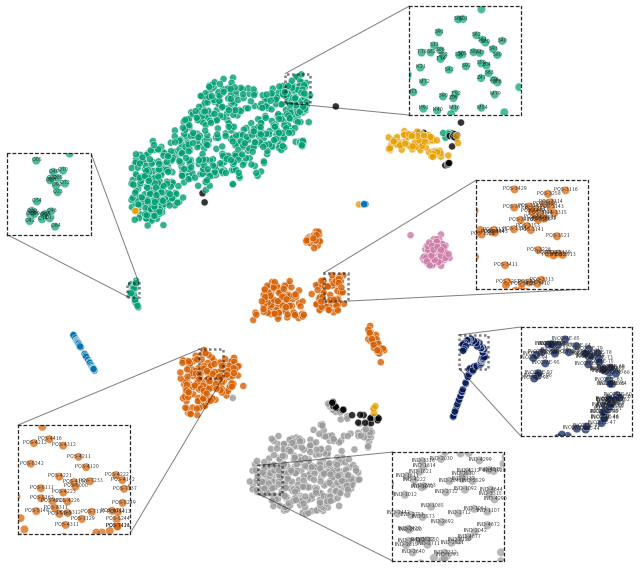

In [15]:
### 1. Specify Coordinates
x_coords = xp[:,0]  
y_coords = xp[:,1] 
v = vocab["TOKEN"].tolist()

# Define main figure and axis.
fig, ax = plt.subplots(figsize=(10,10))

# Plot the main scatter plot.
ax.scatter(xp[:,0], xp[:,1], c=c,  s=50, edgecolors="white", linewidths=0.5, alpha=0.8)

# Define regions to zoom in on (using data coordinates).

### Region S
region_S = [-1, 1.6, 15.6, 18.2] # w=2.6
box_S = [0.7, 0.82, 0.2, 0.2]
# Region P3
region_P3 = [3.0, 5.5, -2, 0.5] # w=2.5
box_P3 = [0.82, 0.5, 0.2, 0.2]
### Region P4
region_P4 = [-9.9, -7.4, -8.8 , -6.3] # w=2.5
box_P4 = [0, 0.05, 0.2, 0.2]
### Region I1
region_I1 = [-3.8, -1.3, -19.1, -16.6] # w=2.5
box_I1 = [0.67, 0.00, 0.2, 0.2]
### Region INC
region_INC = [17, 20, -8, -5] # w=3
box_INC = [0.9, 0.23, 0.2, 0.2]
### Region O
region_O = [-17.3, -16.1, -1.6, -0.4] # w=1.2
box_O = [-.02, 0.6, 0.15, 0.15]



insert_subplot(ax, region_S, box_S)
insert_subplot(ax, region_P3, box_P3)
insert_subplot(ax, region_P4, box_P4)
insert_subplot(ax, region_I1, box_I1)
insert_subplot(ax, region_INC, box_INC)
insert_subplot(ax, region_O, box_O)

plt.autoscale()
plt.axis("off")
# Show the plot.
plt.rcParams["text.usetex"] = True
plt.rcParams["pdf.fonttype"] = 42
plt.savefig(save_path + "concept_space.pdf", format="pdf", bbox_inches="tight")

plt.show()
def cosine_distances(token: str, x):
    output = list()
    idx = np.argwhere(vocab["TOKEN"].values == token).item()
    for i in range(x.shape[0]):
        output.append(cosine(x[idx], x[i]))
    return np.array(output)

In [20]:
def cosine_distances(token: str, x):
    output = list()
    idx = np.argwhere(vocab["TOKEN"].values == token).item()
    for i in range(x.shape[0]):
        output.append(cosine(x[idx], x[i]))
    return np.array(output)

#### Cosine Distance to Concept
top_n = 10
token= "IND_2821"
dist = cosine_distances(token, xh)
idx = np.argsort(dist)[:top_n]

d = list()
for k ,v in zip(vocab["TOKEN"].values[idx], dist[idx]):
    d.append((k,v))
    print(k,"%.3f" %v)
pd.DataFrame(d, columns=["Token", "Cosine Similarity"]).to_csv("%s_neighbours.csv" %token)

IND_2821 0.000
IND_2573 0.480
IND_4672 0.491
IND_3092 0.535
IND_2530 0.539
IND_3101 0.560
IND_4222 0.571
IND_1470 0.571
IND_3530 0.585
IND_2711 0.598
